In [2]:
import gym
import numpy as np
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
env = gym.make('ma_gym:PredatorPrey5x5-v0')

# --------------------------------------------------------------------------------------------------------------

## Environment Dynamics:

In [6]:
def state_to_encoding(state):
    encoding = 0
    for i in range(len(state)):
        encoding += (5**(5-i))*int(state[i])
    return encoding

In [7]:
def encoding_to_state(encoding):
    state = ""
    for i in range(5, 0, -1):
        remainder = encoding % 5
        encoding = encoding//5
        state = str(remainder) + state
    remainder = encoding % 5
    state = str(remainder) + state
    return state

In [8]:
def action_to_encoding(action):
    encoding = 0
    for i in range(len(action)):
        encoding += (5**(1-i))*int(action[i])
    return encoding

In [9]:
def encoding_to_action(encoding):
    action = ""
    remainder = encoding % 5
    encoding = encoding//5
    action = str(int(remainder)) + action
    remainder = encoding % 5
    action = str(int(remainder)) + action
    return action

In [10]:
# def get_custom_reward(state, action, next_state):
    
#     terminate = False
    
    
#     #Encoding in general means the number, state is the string
#     state = encoding_to_state(state)
#     action = encoding_to_action(action)
#     next_state = encoding_to_state(next_state)
    
#     noop_1 = 0
#     noop_2 = 0
    
#     #PREDATOR 1 NOOPING:
#     if action[0] == "4":
#         if (abs(int(state[4]) - int(state[0])) == 1 and abs(int(state[5]) - int(state[1])) == 0) or (abs(int(state[4]) - int(state[0])) == 0 and abs(int(state[5]) - int(state[1])) == 1):
#             noop_1 = 1
    
#     #PREDATOR 2 NOOPING:
#     if action[1] == "4":
#         if (abs(int(state[4]) - int(state[2])) == 1 and abs(int(state[5]) - int(state[3])) == 0) or (abs(int(state[4]) - int(state[2])) == 0 and abs(int(state[5]) - int(state[3])) == 1):
#             noop_2 = 1
    
#     #REWARD ASSIGNMENT:
    
#     if (noop_1 + noop_2) == 2:          #Correct Noop
#         reward = 1
        
#     elif (noop_1 + noop_2) == 1:        #Wrong Noop       
#         reward = -0.5
    
#     elif (action[0] == "4" and noop_1 == 0) or (action[1] == "4" and noop_2 == 0):  #Terrible Noop
#         reward = -1
   
#     #Collision:
#     elif (next_state[:2] == next_state[2:4]) or (next_state[2:4] == next_state[4:]) or (next_state[:2] == next_state[4:]):
#         reward = -0.5
    
#     #Movement Collision:
#     elif (next_state[:2] == state[2:4] and state[:2] == next_state[2:4]) or (next_state[4:] == state[2:4] and state[4:] == next_state[2:4]) or (next_state[:2] == state[4:] and state[:2] == next_state[4:]):
#         reward = -0.5
    
#     else:
#         reward = -0.01
        
    
#     return reward
    
    
def get_custom_reward(state, action, next_state):
    
    
    #Encoding in general means the number, state is the string
    state = encoding_to_state(state)
    action = encoding_to_action(action)
    next_state = encoding_to_state(next_state)
    
    noop_1 = 0
    noop_2 = 0
    
    #PREDATOR 1 NOOPING:
    if (abs(int(next_state[4]) - int(next_state[0])) == 1 and abs(int(next_state[5]) - int(next_state[1])) == 0) or (abs(int(next_state[4]) - int(next_state[0])) == 0 and abs(int(next_state[5]) - int(next_state[1])) == 1):
        noop_1 = 1
    
    #PREDATOR 2 NOOPING:
    if (abs(int(next_state[4]) - int(next_state[2])) == 1 and abs(int(next_state[5]) - int(next_state[3])) == 0) or (abs(int(next_state[4]) - int(next_state[2])) == 0 and abs(int(next_state[5]) - int(next_state[3])) == 1):
        noop_2 = 1

    #REWARD ASSIGNMENT:
    
    if (noop_1 + noop_2) == 2:          #Correct Noop
        reward = 1
        
#     elif (noop_1 + noop_2) == 1:        #Wrong Noop       
#         reward = -0.5
    
    elif (action[0] == "4" and noop_1 == 0) or (action[1] == "4" and noop_2 == 0):  #Terrible Noop
        reward = -1
   
    #Collision:
    elif (next_state[:2] == next_state[2:4]) or (next_state[2:4] == next_state[4:]) or (next_state[:2] == next_state[4:]):
        reward = -0.5
    
    #Movement Collision:
    elif (next_state[:2] == state[2:4] and state[:2] == next_state[2:4]) or (next_state[4:] == state[2:4] and state[4:] == next_state[2:4]) or (next_state[:2] == state[4:] and state[:2] == next_state[4:]):
        reward = -0.5
    
    else:
        reward = -0.01
        
    
    return reward
    

## Agent: 

In [52]:
class Agent():
    
    def __init__(self, env, name):
        
        self.name = name
        
        #Environment properties
        self.env = env
        self.n = len(self.env.observation_space) + 1              # 1 prey
        self.num_states = 5**(2*self.n)    # 5 rows/columns squared for area and multiplied by number of agents including prey
        self.num_actions = 5*5
        
        #Agent properties:
        self.values = np.zeros((self.num_states, self.num_actions))            
        self.policy = np.zeros(self.num_states, )
        
        #Evaluation parameters:
        self.num_visits = np.zeros((self.num_states, self.num_actions))
        self.episode_lengths = np.array([])
        self.successful_episodes = 0
        self.total_rewards = np.array([])   #Because taking average rewards defeats the point of prefering faster episodes
        
        #Training parameters
        self.epsilons = np.array([])
        self.gammas = np.array([])
        
        
    def get_state_from_env(self):
    
        a1_pos = str(self.env.agent_pos[0][0]) + str(self.env.agent_pos[0][1])
        a2_pos = str(self.env.agent_pos[1][0]) + str(self.env.agent_pos[1][1])
        prey_pos = str(self.env.prey_pos[0][0]) + str(self.env.prey_pos[0][1])

        state_string = a1_pos + a2_pos + prey_pos
        state_encoding = state_to_encoding(state_string)

        return state_string, state_encoding
    
    
    def choose_action(self, state_encoding, epsilon):
        
        action = [0, 0]
        
        explore = np.random.choice([False, True], p = [1 - epsilon, epsilon])
        if explore:
            action_encoding = np.argmin(self.num_visits[state_encoding, :])
        else:
            action_encoding = self.policy[state_encoding]

        action_string = encoding_to_action(action_encoding)
        action[0], action[1] = int(action_string[0]), int(action_string[1])
        
        return action, action_string, action_encoding
    
    
    def update_policy(self, states, actions, rewards, gamma):
    
        G = 0
        prev_num_visits = self.num_visits[:]

        for i in range(len(states) - 1, -1, -1):

            G = gamma*G + rewards[i]

            if self.num_visits[states[i], actions[i]] == prev_num_visits[states[i], actions[i]]:

                n = self.num_visits[states[i], actions[i]] 
                self.values[states[i], actions[i]] = (n*self.values[states[i], actions[i]] + G)/(n+1)
                self.num_visits[states[i], actions[i]] += 1

                self.policy[states[i]] = np.argmax(self.values[states[i], :])
                
    
    def monte_carlo_control(self, gammas, epsilons, save = False):
        
        _ = self.env.reset()
        self.env.render()
        _ = input("Ready to start?")
        
        num_episodes = gammas.size
        
        for ep in range(num_episodes):
            
            #Generate an Episode:
    
            dones = [False for _ in range(self.env.n_agents)]
            
            states = []
            actions = []
            rewards = []
            
            _ = self.env.reset()
            self.env.render()
            
            steps = 0
            
            while (not all(dones)) and steps<100:
                
                gamma = gammas[steps]
                epsilon = epsilons[steps]
                
                state_string, state_encoding = self.get_state_from_env()
                action, action_string, action_encoding = self.choose_action(state_encoding, epsilon)
                
                states.append(int(state_encoding))
                actions.append(int(action_encoding))
                
                if steps>0:
                    rewards.append(get_custom_reward(states[-2], actions[-2], states[-1]))
                
                _, reward, dones, info = self.env.step(action)
                
                self.env.render()
                steps += 1
                
            state_string, state_encoding = self.get_state_from_env()
            rewards.append(get_custom_reward(states[-1], actions[-1], state_encoding))
            
            #Start policy update:
            self.update_policy(states, actions, rewards, gamma) 
            
            if rewards[-1] == 1:
                self.successful_episodes += 1
            
            self.total_rewards = np.append(self.total_rewards, np.sum(rewards))
            self.episode_lengths = np.append(self.episode_lengths, steps)
            
            self.gammas = np.append(self.gammas, gammas)
            self.epsilons = np.append(self.epsilons, epsilons)
            
            print("Episodes completed = ", ep)
            clear_output(wait=True)
            
            if save:
                self.save_agent()
                
                
    def analyse_episode(self):
        
        dones = [False for _ in range(self.env.n_agents)]
        action = [0, 0]
        reward = [0, 0]
        info = None
        
        _ = self.env.reset()
        count = 0
        
        self.env.render()
        _ = input("Press Enter to start simulation")
        
        while not all(dones):
            
            #clear_output(wait = True)
            self.env.render()
            
            a1_pos = str(self.env.agent_pos[0][0]) + str(self.env.agent_pos[0][1])
            a2_pos = str(self.env.agent_pos[1][0]) + str(self.env.agent_pos[1][1])
            prey_pos = str(self.env.prey_pos[0][0]) + str(self.env.prey_pos[0][1])
            
            state_string = a1_pos + a2_pos + prey_pos
            state_encoding = state_to_encoding(state_string)
            action_encoding = self.policy[state_encoding]
            action_string = encoding_to_action(action_encoding)
            action[0], action[1] = int(action_string[0]), int(action_string[1])
            print(action_dict[action[0]], action_dict[action[1]])
            print("\nCurrent state in their representation = ", state_string)
            _ = input("Does the action make sense? Press Enter to execute")
            _, reward, dones, info = self.env.step(action)
            print("Is agent done?: ", dones)
            self.env.render()

            
    def save_agent(self):
        
        #Agent properties:
        np.save(self.name + "/" + self.name + "_values.npy", self.values)
        np.save(self.name + "/" + self.name + "_policy.npy", self.policy)
        
        #Evaluation parameters:
        np.save(self.name + "/" + self.name + "_num_visits.npy", self.num_visits)
        np.save(self.name + "/" + self.name + "_episode_lengths.npy", self.episode_lengths)
        np.save(self.name + "/" + self.name + "_successful_episodes.npy", self.successful_episodes)
        np.save(self.name + "/" + self.name + "_total_rewards.npy", self.total_rewards)
        
        #Training parameters:
        np.save(self.name + "/" + self.name + "_epsilons.npy", self.epsilons)
        np.save(self.name + "/" + self.name + "_gammas.npy", self.gammas)
        
    
    def load_agent(self):
        
        #Agent properties:
        self.values = np.load(self.name + "/" + self.name + "_values.npy")
        self.policy = np.load(self.name + "/" + self.name + "_policy.npy")
        
        #Evaluation parameters:
        self.num_visits = np.load(self.name + "/" + self.name + "_num_visits.npy")
        self.episode_lengths = np.load(self.name + "/" + self.name + "_episode_lengths.npy")
        self.successful_episodes = np.load(self.name + "/" + self.name + "_successful_episodes.npy")
        self.total_rewards = np.load(self.name + "/" + self.name + "_total_rewards.npy")
        
        #Training parameters:
        self.epsilons = np.load(self.name + "/" + self.name + "_epsilons.npy")
        self.gammas = np.load(self.name + "/" + self.name + "_gammas.npy")
        

In [54]:
agent = Agent(env, "MC_agent_1")

In [55]:
agent.load_agent()

In [53]:
agent.env.close()

In [57]:
num_episodes = 3000

gamma = np.ones(num_episodes) * 0.9
epsilon = np.ones(num_episodes) * 0.5

agent.monte_carlo_control(gamma, epsilon, save = True)

Episodes completed =  2999


In [40]:
agent.total_rewards.shape

(4914,)

In [50]:
agent.successful_episodes

array(3785)

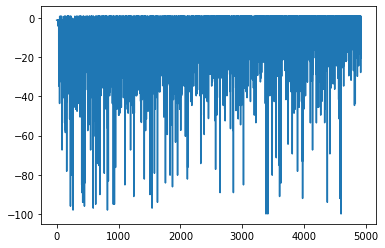

In [46]:
plt.plot(agent.total_rewards)

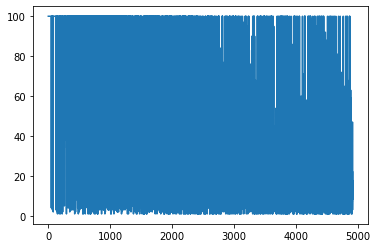

In [37]:
plt.plot(agent.episode_lengths)

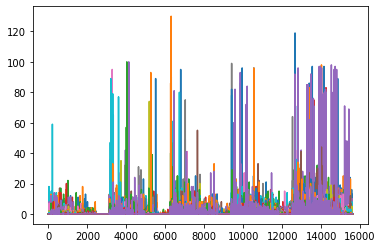

In [36]:
plt.plot(agent.num_visits)

In [64]:
np.max(agent.total_rewards)

-0.01

In [15]:
action_dict = {0:"Down", 1:"Left", 2:"Up", 3:"Right", 4:"Noop"}
agent.analyse_episode()

Press Enter to start simulation
Down Left

Current state in their representation =  223203
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Down Up

Current state in their representation =  223102
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Down

Current state in their representation =  322103
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Up

Current state in their representation =  312104
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Right Right

Current state in their representation =  301103
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Down Noop

Current state in their representation =  311203
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Noop

Current state in their representation =  411204
Does the action make sense? Press Enter to execute
Is agent

Is agent done?:  [False, False]
Up Left

Current state in their representation =  423310
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Down Down

Current state in their representation =  323300
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Up Down

Current state in their representation =  424300
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Down Up

Current state in their representation =  324300
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Right

Current state in their representation =  423300
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Up Left

Current state in their representation =  413410
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Left

Current state in their representation =  313300
Does the action make sense? Press Enter to execute
Is agent done

In [22]:
def value_heatmap(values, half_state = "2233"):
    
    heatmap = np.zeros((5,5))
    
    for i in range(5):
        for j in range(5):

            state_encoding = state_to_encoding(str(i) + str(j) + half_state)
            heatmap[i, j] = np.mean(values[state_encoding, :])
            
    return heatmap

[[-2.88029515e+00 -2.73801415e+00 -1.70417279e+00 -1.41973136e-01
   0.00000000e+00]
 [-3.32012845e+00 -3.16612801e+00 -1.78982501e+00 -8.45625087e-01
   0.00000000e+00]
 [-3.52152620e+00 -3.34311050e+00  0.00000000e+00 -4.00000000e-04
  -1.30831872e-01]
 [-2.97888619e+00 -3.10997406e+00 -2.20607257e-01  0.00000000e+00
  -2.93791867e-01]
 [-3.17500251e+00 -2.80480704e+00 -2.52051120e+00 -6.65981825e-01
  -1.64005864e+00]]


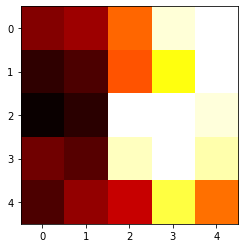

In [65]:
heatmap = value_heatmap(agent.values, half_state = "2233")
print(heatmap)
plt.imshow(heatmap, cmap="hot", interpolation="nearest")

(15625, 25)


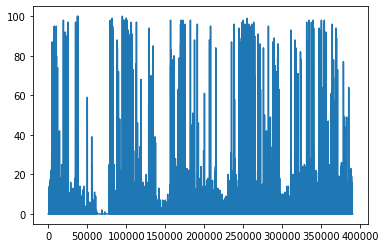

In [66]:
print(agent.num_visits.shape)
plt.plot(agent.num_visits[:].flatten())

In [68]:
np.min(agent.num_visits)

0.0